In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import matplotlib.ticker as mticker
import time as t
import scipy

## Defining Constants

In [2]:
### Here we define constants from the QMC model

w1   = 0.3400     ### Fitting constant for sigma meson (unitless)
w2   = 0.3688     ### Fitting constant for sigma meson (unitless)
wom  = 1/3        ### Fitting constant for omega meson (unitless)
d    = 0.176      ### Fitting constant for effective mass in [fm]
MeV  = 197.3      ### Conversion for [fm^-1] -> [MeV]
MX   = 1314.86    ### Mass of Xi baryon in [MeV]
msig = 504    ### Mass of sigma Meson [MeV]
k    = 1.43996    ### Coulomb constant (MeV.fm.e^-2)
    
    
### Here we define constants for the Woods-saxon potential
aWS  = 0.6        ### W-S Density constant in [fm]
c    = 1.1        ### W-S Constant multiplying A^1/3 term
rho0 = 0.15       ### Nuclear matter density in [fm^-3]

### Defining the Nucleon and Proton numbers for nuclei tested.

### Nucleon numbers
APb = 208
ALa = 139
AY  = 89
AV  = 51
ACa = 40
AS  = 32

### Proton numbers
ZPb = 82
ZLa = 57
ZY  = 39
ZV  = 23
ZCa = 20
ZS  = 16

# Defining Coulomb Potential

The Coulomb potential is defined by the equation:

$$V(r) =  8ke \int dq  \int dr' r'^2 j_0(qr)  \rho_c(r') j_0(qr')$$

Where here $\rho_c$ is the charge density, which goes like the proton density, normalised to the number of protons present.

In [3]:
### Calculating  the normalisation, such that the the integral of the charge density returns Z
def NormCalculator(Z):
    integrand = lambda r, Z: 4*np.pi*r**2/(1+np.exp((r-c*Z**(1/3))/aWS)) 
    norm      = integrate.quad(integrand, 1e-4, 10, args = Z)[0]
    return norm

### Definining the Charge Density, using the normalisation above
def ChargeRho(x, norm, Z):
    val = Z/(norm*(1+np.exp((x-c*Z**(1/3))/aWS)))   
    return val

### Defining the Coulomb potential, as a double integral over r' and q. 
@np.vectorize
def V_Coulomb2(r, norm, Z):
    ### Defining Limits for the r' integral
    Upperlim  = lambda x: 20
    Lowerlim  = lambda x: 1e-4
    ### Integrand to be integrated.
    Integrand = lambda x, q, r, norm, Z: -8*k*Z/r* np.sin(q*r)/q**2*ChargeRho(x, norm, Z)*x*np.sin(q*x)
    return integrate.dblquad(Integrand, 1e-4, 10, Lowerlim, Upperlim, args = (r, norm, Z))

## Defining a Function to read in Finite Coulomb Potential

Due to the Double quad integration being a relatively slow process, to speed this up it was decided to record the values for the integral in a number of files, and then have a function that will read the functions back in.

In [4]:
def CoulombReader(Z): 
    ### Taking in the proton number, to determine which file to open
    
    ### Reading in Pb
    if (Z == ZPb):
        Data = open('FiniteCoulombPotPb.csv', 'r')
        VC = np.loadtxt(Data)[:]
    
    ### Reading in La
    if (Z == ZLa):
        Data = open('FiniteCoulombPotLa.csv', 'r')
        VC = np.loadtxt(Data)[:]
    
    ### Reading in Y
    if (Z == ZY):
        Data = open('FiniteCoulombPotY.csv', 'r')
        VC = np.loadtxt(Data)[:]
    
    ### Reading in V
    if (Z == ZV):
        Data = open('FiniteCoulombPotV.csv', 'r')
        VC = np.loadtxt(Data)[:]
    
    ### Reading in Ca
    if (Z == ZCa):
        Data = open('FiniteCoulombPotCa.csv', 'r')
        VC = np.loadtxt(Data)[:]
    
    ### Reading in S
    if (Z == ZS):
        Data = open('FiniteCoulombPotS.csv', 'r')
        VC = np.loadtxt(Data)[:]
    ### Closing the file
    Data.close()
    ### Returning the potential
    return VC

### Defining Potentials and Woods-Saxon Density

In [5]:
### Defining the Woods-Saxon density and it's derivatives

def rho(r, A):
    val = rho0/(1+np.exp((r-c*A**(1/3))/aWS))
    return val

def diffrho(r, A):
    exparg = np.exp((r-c*A**(1/3))/aWS)
    val = rho0*(-2*aWS*(1+exparg)-r*(1-exparg))*exparg/(aWS**2*r*(1+exparg)**3)
    return val

def diff2rho(r,A):
    exparg = np.exp((r-c*A**(1/3))/aWS)
    val = 2*rho0**2*(-2*aWS*(exparg+1)-r*(1-exparg))*exparg/(aWS**2*r*(1+exparg)**4)
    return val

def diffrhosquare(r,A):
    exparg = np.exp((r-c*A**(1/3))/aWS)
    val = -2*rho0*exparg/(aWS*(1+exparg)**3)
    return val

### Defining the many-body potential (No angular part at this stage)

def V(r, A, Z, Gsig, Gom, Grho, VC, l):
    c1   = -w1*Gsig*MeV + wom*Gom*MeV           ### 2-Body Forces
    c2   =  (d*w2/2+d*w1)*Gsig**2*MeV           ### 3-Body Forces
    c3   = -(d**2*w1+d**2*w2)*Gsig**3*MeV       ### 4-Body Forces

    ### Iso-spin dependent terms
    b    =  Grho/4 * (rho(r,Z)-rho(r,A-Z))*MeV

    
    ### Derivative terms
    drho_drho  =  -d*Gsig**2*(w1+w2)*diffrho(r, A)**2/msig**2*MeV
    drho2_drho =   Gsig**3*d**2*(w1+w2)*diffrho(r,A)*diffrhosquare(r,A)/msig**2*MeV
    d2rho      =   Gsig**3*d**2*(w1+2*w2)*rho(r,A)*diff2rho(r,A)/msig**2*MeV
    
    ### Velocity-dependent terms
    Inverse      = 1+(Gsig*rho(r,A)*w1/MX-Gsig**2*rho(r,A)**2*d*(w1+w2/2)/MX+Gsig**3*rho(r,A)**3*d**2*(w1+w2)/MX)*MeV
    Inverse_drho = (w2*d*Gsig**2*diffrho(r,A)**2-Gsig**3*d**2*w2*diffrho(r,A)*diffrhosquare(r,A)-d2rho*msig**2/MeV)*MeV/(MX*msig**2)
   
    
    ### Angular momentum term
    if l==0:
        Ang = 0
    else:
        Ang  =  l*(l+1)/(2*MX*r**2)*MeV**2
        
    ### The derivative terms are only a small correction, however when introduced to sulfur,
    ### the functionality of the classicalturningpoint function is disturbed.
    ### Hence they have been turned off in the calculation of sulfur.
    if A == AS:
        result = (c1*rho(r,A)+c2*rho(r,A)**2+c3*rho(r,A)**3+VC+b+drho_drho)/(Inverse)+Ang
    else:
        result = (c1*rho(r,A)+c2*rho(r,A)**2+c3*rho(r,A)**3+VC+b+drho_drho + drho2_drho +d2rho)/(Inverse+Inverse_drho)+Ang
    
    return result


## Second form for the Potential

The velocity dependent term also modifies the energy eigenvalue, and thus I had to include a second function for inputting into the Numerov Algorithm which accounts for this. We have here:
$\frac{(E-V(r))}{\text{Velocity-dependent terms}}$

And we note that from rearranging the Hamiltonian from the EoM that the angular momentum term is unaffected by the velocity-dependence, so we simply add it to the other term involved.

In [6]:
### Defining New form for Potential w/ fix for Velocity-dependence
def VTwo(r, A, Z, E, Gsig, Gom, Grho, VC, l):
    c1   = -w1*Gsig*MeV + wom*Gom*MeV            ### 2-Body Forces
    c2   =  (d*w2/2+d*w1)*Gsig**2*MeV            ### 3-Body Forces
    c3   = -(d**2*w1+d**2*w2)*Gsig**3*MeV        ### 4-Body Forces    
    
    ### Derivative terms
    drho_drho  =   -d*Gsig**2*(w1+w2)*diffrho(r, A)**2/msig**2*MeV
    drho2_drho =   Gsig**3*d**2*(w1+w2)*diffrho(r,A)*diffrhosquare(r,A)/msig**2*MeV
    d2rho      =   Gsig**3*d**2*(w1+2*w2)*rho(r,A)*diff2rho(r,A)/msig**2*MeV
    
    ### Velocity-Dependent Terms
    Inverse      = 1+(Gsig*rho(r,A)*w1/MX-Gsig**2*rho(r,A)**2*d*(w1+w2/2)/MX+Gsig**3*rho(r,A)**3*d**2*(w1+w2)/MX)*MeV
    Inverse_drho = (w2*d*Gsig**2*diffrho(r,A)**2-Gsig**3*d**2*w2*diffrho(r,A)*diffrhosquare(r,A)-d2rho*msig**2/MeV)*MeV/(MX*msig**2)
       
    ### Isospin-Dependent Term
    b    =  Grho/4 * (rho(r,Z)-rho(r,A-Z))*MeV

    ### Angular momentum term
    if l==0:
        Ang = 0
    else:
        Ang  =  l*(l+1)/(2*MX*r**2)*MeV**2
      
    ### The derivative terms are only a small correction, however when introduced to sulfur,
    ### the functionality of the classicalturningpoint function is disturbed.
    ### Hence they have been turned off in the calculation of sulfur.
    if A == AS:
        result = (E-(c1*rho(r,A)+c2*rho(r,A)**2+c3*rho(r,A)**3 + VC + b))/(Inverse)+Ang
    
    else:
        result = (E-(c1*rho(r,A)+c2*rho(r,A)**2+c3*rho(r,A)**3 + VC + b + drho_drho + d2rho + drho2_drho))/(Inverse+Inverse_drho)+Ang
    
    return result    

## Defining Classical Turning Point Function

Now we will define some functions which will help to find solutions. We have one function which finds the classical turning point, which is the point where $E-V(r)$, changes sign. When solving using the numerov algorithm we will solve from either side, and match the solutions at the matchpoint which will be this classical turning point.

In [7]:
### Function to find the classical turning point of the potential

def ClassicalTurningPoint(x, N, A, Z, E, Gsig, Gom, Grho, VC, l):
    imatch=0
    VVec = VTwo(x, A, Z, E, Gsig, Gom, Grho, VC, l)
    for j in range(N-1):  #classical right turning point
        DE1 = VVec[j]
        DE2 = VVec[j+1]
        D1D2=DE1*DE2
        if D1D2<=0  and DE1 > 0:  #match point
            imatch = j+1
    return imatch


# Implementing The Numerov Algorithm

The numerov algorithm is used to solve equations of the form:
$\frac{d^2 y}{dx^2} = f(x)y(x)$.

When applying this to solve the schrodinger in this situation, the equation we have is in the form:

$\frac{d^2\psi}{dr^2} = -2M_\Lambda \left[ \frac{1}{\eta(r)}[E - V_{binding}(r)] -\frac{l(l+1)}{2M_\Lambda r^2} \right]\psi(r)$, which is in the form $\frac{d^2 \psi}{dr^2} = f(r)y(r)$

Where here, $\eta(r)$ is the velocity dependent term, which has the form: $\eta(r) = \left[1+ \frac{1}{M_\Lambda}G_\sigma w \rho_N  - \frac{1}{M_\Lambda}\left( w+\frac{\tilde{w}}{2}\right) dG_\sigma^2 \rho_N^2  +\frac{1}{M_\Lambda}\left( w +  \tilde{w} \right)  d^2G_\sigma^3 \rho^3_N \right]$.

$V_{binding}(r)$ is the binding potential, which has the form: $V_{binding} = -G_\sigma w \rho_N(r) +w_\omega G_\omega  \rho_N(r) + \left( w+\frac{\tilde{w}}{2}\right) dG_\sigma^2 \rho_N^2(r)  -\left( w +  \tilde{w} \right)  d^2G_\sigma^3 \rho^3_N(r) + V_{Derivative}$.

Where $V_{Derivative}$ are the derivative terms, and the final term is the term containing the angular momentum dependence.

We note then that calling the function VTwo in the code is calling $f(r)$, as in the algorithm above, up to a factor of $2M_\Lambda$, which is instead included in the numerov solver below.

In [8]:
### Code to implement the Numerov Algorithm, for the left and right Solutions


def NumerovLeft(x, psi0, psi1, A, Z, E, h, Gsig, Gom, Grho, VC, l, imatch):
    
    VVec = VTwo(x, A, Z, E, Gsig, Gom, Grho, VC, l)
    h2 = h**2
    h12 = h2/12
    
    mh12 = 2*MX*h12/(MeV**2)
    
    PsiL = np.zeros(imatch)
    
    PsiL[0] = psi0
    PsiL[1] = psi1
    
    for i in range(2, imatch):
        W2 = 1+mh12*(VVec[i])
        W1 = 2*(1-(5*mh12)*(VVec[i-1]))*PsiL[i-1]
        W0 = (1+mh12*(VVec[i-2]))*PsiL[i-2]
        
        PsiL[i] = (W1-W0)/W2
    
    return PsiL
    
def NumerovRight(x, psiN, psiNm1, A, Z, E, h, Gsig, Gom, Grho, VC, l, imatch):
    
    VVec = VTwo(x, A, Z, E, Gsig, Gom, Grho, VC, l)
    
    h2 = h**2
    h12 = h2/12
    dim = N-imatch
    
    mh12 = 2*MX*h12/(MeV**2)
        
    PsiR    = np.zeros(dim)
    PsiR[0] = psiN
    PsiR[1] = psiNm1
    
    for i in range(2, dim):
        W2 = 1+mh12*(VVec[i])
        W1 = 2*(1-(5*mh12)*(VVec[i-1]))*PsiR[i-1]
        W0 = (1+mh12*(VVec[i-2]))*PsiR[i-2]
        
        PsiR[i] = (W1-W0)/W2
       
    PsiR = np.flip(PsiR)
    return PsiR

# Defining a Function to find Energy Eigenstate

We now have functions to calculate the wavefunction for a given energy, so we now need to put this together to find a valid energy eigenstate. This process works by:

1. We make an initial guess for what the energy should be

2. Solve for the wavefunction for the given energy using the numerov algorithm. We solve the equation by finding the classical energy turning point, and integrating from the left to the match point, and indenpendently from the right to the match point. This allows for us to test whether the energy is a valid energy eigenstate, and also helps to minimise numerical errors.

3. We then enforce continuity by scaling the left side solution to match that at the right side

4. After normalising the wavefunction we can test for smoothness. If the wavefunction is smooth we have found a valid energy eigenstate. If it is not then we increment the energy by an amount dE until we find a valid solution.

5. Once we have a valid solution it is possible that there would be some uncertainty in the exact value for the energy, so we continue to increment by dE and test for a solution. Once the solution is no longer valid for a given energy we have found an upper and lower bound for the energy eigenstate.


In [9]:
def Find_Energy(x, A, Z, Ein, dE, Gsig, Gom, Grho, VC, l, psi0, psi1, psiNm1, psiN, maxit, eps):
    
    E     = Ein
    Psi   = np.zeros(N)
    check = 0
    Eerr  = 0
    dE = np.abs(dE)
    for i in range(maxit):
        
        ### Finding Solutions to the Schrodinger Equation
        matchP = ClassicalTurningPoint(x, N, A, Z, E, Gsig, Gom, Grho, VC, l)
        if matchP ==0:
            E = E + dE
            continue
        PsiL = NumerovLeft(x, psi0, psi1, A, Z, E, h, Gsig, Gom, Grho, VC, l, matchP)
        PsiR = NumerovRight(x, psiN, psiNm1, A, Z, E, h, Gsig, Gom, Grho, VC, l, matchP)
        
        
        ### Ensuring Continuity by scaling the functions, at the match point.
        PsiLm = PsiL[matchP-1]
        PsiRm = PsiR[0]
        scale = PsiLm/PsiRm
        PsiR  = scale*PsiR
        
        ### Normalising Psi, before testing for Smoothness
        Psi     = np.concatenate((PsiL, PsiR), axis=None)
        Psi2    = np.abs(Psi**2)
        Norm    = integrate.simps(4*np.pi*Psi2, x)
        PsiNorm = Psi/np.sqrt(Norm)
        
        ### Testing for Smoothness
        
        PsiLmm1 = PsiL[matchP-2]
        PsiRmp1 = PsiR[1]
        diff = np.abs(PsiLmm1+PsiRmp1-2*PsiLm)/(2*np.sqrt(Norm)*h)       
        
        ### Iterating to find the solution to the energy
        ### First we would have found the lower bound for the energy 
        ### This is because we add to the energy inputted (which has a negative value)
        ### So we check if we find the lower bound, then shift to find the upper
        if diff<eps and check==0:
            ### Set the lower bound for the energy
            Elow  = E
            E     = E+dE
            Eup   = E
            ### Setting the check to 1, so the program knows we are searching for the upper bound
            check = 1
            
       
        ### Now we continue iterating to find the upper bound
        elif diff<eps and check==1:
            Eup = E
            E   = E+dE
        
        ### Now once we find a solution where the derivative is greater than the allowed error
        ### we calculate the mean energy and the uncertainity in the energy.
        elif diff>eps and check==1:
            E = (Eup+Elow)/2            ### Return the Mean energy
            Eerr = np.abs((Eup-Elow)/2) ### And return the uncertainty in the energy
            
            ### We break out of the loop once the energy has been found
            print('Energy Found for A', A, 'And l', l, 'Energy is,', E)
            break
       
        ### This step is for iterating before we have found the lower bound
        else:
            E = E+dE

    return E, Eerr

# Function to find Energy Eigenstates of multiple Nuclei

We now wish to calculate all the binding energies for a variety of different nuclei. This is done by:

1. Take an initial energy, as an input to the function, for the first nucleus, and then solve for the energy for the 1s state.
3. Set the new input energy as the upper bound for the energy, plus an increment dE
4. Continue to solve for the energy in all the other 1s states. Note it is important that the nucleon number is in descending order for AsVec and ApVec. This ensures that the ground state is found and not higher energy states for example.
5. Set the energy input back to the energy found for the first nucleus, plus a little increment, to solve for the 1p states, repeating steps 2-4 for the 1p states

In [10]:
def Find_Energies(x, AsVec, ApVec, ZVec, XI0, dE, Gsig, Gom, Grho, psi0, psi1, psiNm1, psiN, maxit, eps):
    
    NsVec = np.size(AsVec)
    NpVec = np.size(ApVec)
    
    ### Initialise vectors
    EVec      = np.zeros(NsVec+NpVec)
    EerrVec   = np.zeros(NsVec+NpVec)
    
    if XI0 == False:
        ### If dealing with negative cascade, the sign is opposite to that of the neutral cascade. 
        ### Here you should always input a positive value for the rho coupling
        Grho = -Grho
    ### Loop over energy eigenvalues, updating the Energy in the code each time
    l=0
    for i in range(NsVec):   
        if XI0 == False:
            ### Reading in Finite Coulomb Potential
            VC = CoulombReader(ZVec[i])
            ### Setting energy in.
            Ein = np.amin(V(x, AVec[i], ZVec[i], Gsig, Gom, Grho, VC, l)) + dE
        elif XI0 == True:
            VC = np.zeros(np.size(x))
        ### Calculating the energy
        EVec[i], EerrVec[i] = Find_Energy(x, AsVec[i], ZVec[i], Ein, dE, Gsig, Gom, Grho, VC, l, psi0, psi1, psiNm1, psiN, maxit, eps)
    
    l=1
    ### Initial energy is for the l=0 state of the identical nucleus
    Ein = EVec[0]
    for j in range(NpVec): 
        if XI0 == False:
            ### Reading in Finite Coulomb Potential
            VC = CoulombReader(ZVec[j])
        elif XI0 == True:
            VC = np.zeros(np.size(x))
        ### Calculating the energy
        EVec[NsVec+j], EerrVec[NsVec+j] = Find_Energy(x, ApVec[j], ZVec[j], Ein, dE, Gsig, Gom, Grho, VC, l, psi0, psi1, psiNm1, psiN, maxit, eps)
        ### Shifting the new initial energy to that of the l=0 state for the corresponding nucleus
        Ein                                  = EVec[j+1]
        
    return EVec, EerrVec

# Defining the Constants used in the Solutions

In [11]:
###Defining the grid our solution is on
N = 20000
L = 50
h = L/N
x = np.linspace(1e-4, L, N)

### Defining Function Parameters for Numerov Algorithm

dE  = 0.01
eps = 0.5e-3
maxit = 10000
#BCs
psi0 = 0
psi1 = 0.0001
psiN = 0.000001
psiNm1 = 0.000005

### Defining a vector of nucleon numbers
AVec     = [APb, ALa, AY, AV, ACa, AS]
AVec1p   = [APb, ALa, AY, AV, ACa, AS]
ZVec     = [ZPb, ZLa, ZY, ZV, ZCa, ZS]

In [12]:
### Setting Coupling constants calculated from best fit, and taking Grho=4.71

Gsig = 8.65
Gom  = 5.64
Grho = 4.71

### Setting to solve for negative cascade hyperon
Xi0 = False
### Finding Solutions
XiBE, XierrBE = Find_Energies(x, AVec, AVec1p, ZVec, Xi0, dE, Gsig, Gom, Grho, psi0, psi1, psiNm1, psiN, maxit, eps)

Energy Found for A 208 And l 0 Energy is, -33.28422794452911
Energy Found for A 139 And l 0 Energy is, -25.022390149082455
Energy Found for A 89 And l 0 Energy is, -19.166905393538094
Energy Found for A 51 And l 0 Energy is, -13.664721312717997
Energy Found for A 40 And l 0 Energy is, -13.820176331400507
Energy Found for A 32 And l 0 Energy is, -11.895903836899103
Energy Found for A 208 And l 1 Energy is, -20.919227944527627
Energy Found for A 139 And l 1 Energy is, -14.992390149081066
Energy Found for A 89 And l 1 Energy is, -10.526905393537717
Energy Found for A 51 And l 1 Energy is, -5.219721312718177
Energy Found for A 40 And l 1 Energy is, -4.425176331400707
Energy Found for A 32 And l 1 Energy is, -3.090903836899291


Text(32, 3.090903836899291, '$^{32}S$')

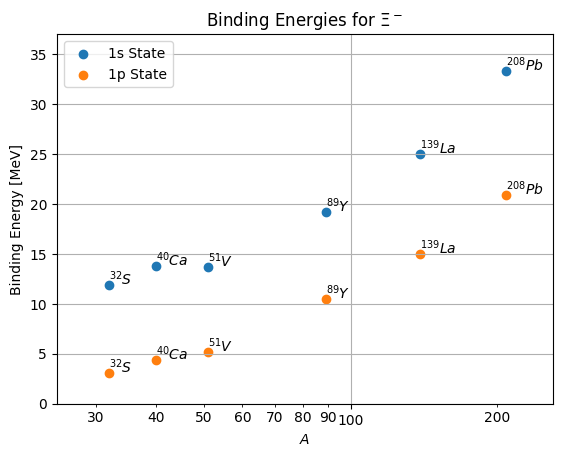

In [13]:
### Annotated Plot of Binding Energies for Grho = 4.71

plt.scatter(AVec, -XiBE[0:6], label = '1s State')
plt.scatter(AVec, -XiBE[6:12], label = '1p State')

plt.xlim(25, 260)
plt.ylim(0, 37)
plt.xscale('log')

ax = plt.gca()

ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)

plt.xlabel('$A$')
plt.ylabel('Binding Energy [MeV]')
plt.legend()
plt.grid()
plt.title('Binding Energies for $\Xi^-$')

plt.annotate('$^{208}Pb$', (208, -XiBE[0]))
plt.annotate('$^{139}La$', (139, -XiBE[1]))
plt.annotate('$^{89}Y$', (89, -XiBE[2]))
plt.annotate('$^{51}V$', (51, -XiBE[3]))
plt.annotate('$^{40}Ca$', (40, -XiBE[4]))
plt.annotate('$^{32}S$', (32, -XiBE[5]))
plt.annotate('$^{208}Pb$', (208, -XiBE[6]))
plt.annotate('$^{139}La$', (139, -XiBE[7]))
plt.annotate('$^{89}Y$', (89, -XiBE[8]))
plt.annotate('$^{51}V$', (51, -XiBE[9]))
plt.annotate('$^{40}Ca$', (40, -XiBE[10]))
plt.annotate('$^{32}S$', (32, -XiBE[11]))